In [1]:
import matplotlib.pyplot as pltimport
import xhermes as xh
from boutdata.data import BoutData
from boutdata import collect
import matplotlib.pyplot as plt
import glob     
import re
import numpy as np
import pandas as pd
from heatflux_functions import *
from data_accessors import *
import xarray as xr

from pathlib import Path
import os, sys, pathlib

sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/sdtools"))

from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.fluxes import *


plt.style.use('ggplot')
plt.rcParams.update({'font.size': 10})
linewidth = 3
markersize = 15


plt.style.use('ggplot')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams.update({'font.size': 14})


def replace_guards(var):
    """
	This in-place replaces the points in the guard cells with the points on the boundary
    
    """
    # Strip the edge guard cells
    var = var[1:-1]

    var[0] = 0.5*(var[0] + var[1])
    var[-1] = 0.5*(var[-1] + var[-2])
    return var

In [2]:
ds = pd.read_pickle('/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/flux_limit/Flux_limiter_detachment_ITER_final.pickle')

print(ds.keys())

Index(['Bxy', 'Ed+_iz', 'Ed+_rec', 'Ed_target_recycle', 'Edd+_cx', 'Fd+_iz',
       'Fd+_rec', 'Fdd+_cx', 'G1', 'G2', 'G3', 'J', 'NVd', 'NVd+', 'Nd', 'Nd+',
       'Ne', 'Pd', 'Pd+', 'Pd+_src', 'Pd_src', 'Pe', 'Pe_src', 'Rd+_ex',
       'Rd+_rec', 'Rneon', 'SNVd', 'SNVd+', 'SNd', 'SNd+', 'SPd', 'SPd+',
       'SPe', 'Sd+_feedback', 'Sd+_iz', 'Sd+_rec', 'Sd+_src', 'Sd_src',
       'Sd_target_recycle', 'Td', 'Td+', 'Te', 'Vd', 'Vd+', 'Ve', 'ddt(NVd)',
       'ddt(NVd+)', 'ddt(Nd)', 'ddt(Nd+)', 'ddt(Pd)', 'ddt(Pd+)', 'ddt(Pe)',
       'density_feedback_src_i_d+', 'density_feedback_src_mult_d+',
       'density_feedback_src_p_d+', 'density_feedback_src_shape_d+', 'g11',
       'g12', 'g13', 'g22', 'g23', 'g33', 'g_11', 'g_12', 'g_13', 'g_22',
       'g_23', 'g_33', 'kappa_par_d', 'kappa_par_d+', 'kappa_par_e', 't_array',
       'ncalls', 'ncalls_e', 'ncalls_i', 'target_temp', 'y', 'alpha',
       'neon_frac', 'Div_Q_SH', 'Div_Q_SNB'],
      dtype='object')


0      1.528220e+10
1      1.528206e+10
2      1.528162e+10
3      1.528104e+10
4      1.528032e+10
           ...     
793    6.572583e+07
794    4.489328e+07
795    2.944170e+07
796    1.817076e+07
797    1.415997e+07
Name: kappa_par_d+, Length: 798, dtype: float64


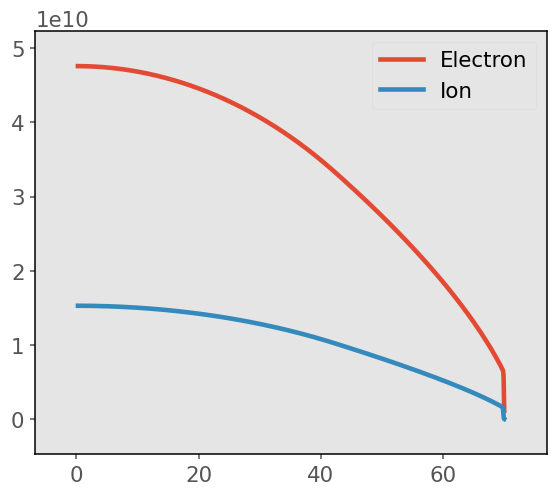

In [3]:
sh = ds[(ds['alpha'] == 'SH') & (ds['neon_frac'] == 0.0)]

y = sh['y']
kappa_e = sh['kappa_par_e'].dropna()
kappa_i = sh['kappa_par_d+'].dropna()
# kappa_e = kappa_e.dropna()

print(kappa_i)

plt.plot(y, kappa_e, label='Electron', linewidth=linewidth)
plt.plot(y, kappa_i, label='Ion', linewidth=linewidth)
plt.legend()

Comparison of electron heat flux calculated according to explicit SH conduction case (using the method described in BOUT++ documentation https://bout-dev.readthedocs.io/en/latest/user_docs/nonlocal.html) and by integrating the div_q output of the SNB case. 

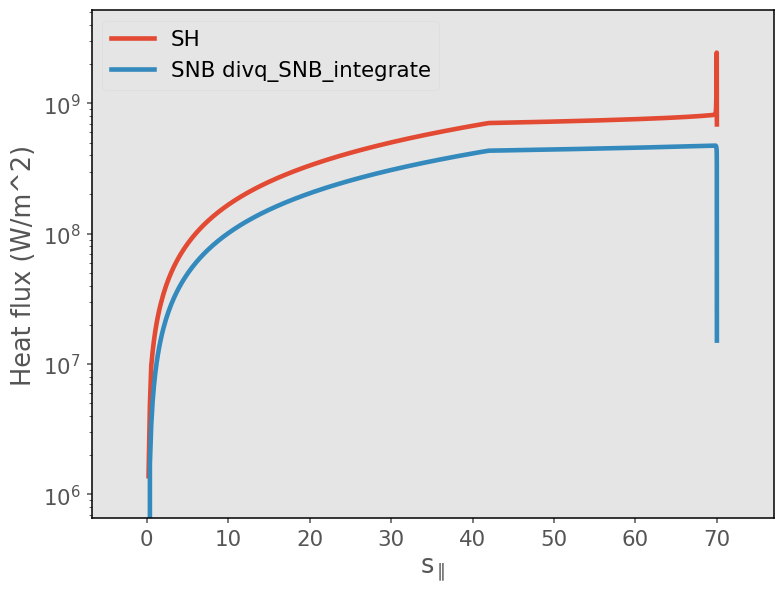

In [4]:
sh = ds[(ds['alpha'] == 'SH') & (ds['neon_frac'] == 0.0)]
snb = ds[(ds['alpha'] == 'SNB') & (ds['neon_frac'] == 0.0)]


x = sh['y']

q_electron = spitzer_q_electron(sh)
q_electron_simply = spitzer_q_electron_simple(sh)
q_electron_int_sh = divq_integrate(snb, False)
q_electron_int_snb = divq_integrate(snb, True)
q_electron_snb = spitzer_q_electron(snb)

fig,ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(x, q_electron, label='SH', linewidth=linewidth)
# ax.plot(x, q_electron_snb, label='SNB spitzer_q_electron (snb)', linewidth=linewidth)
# ax.plot(x, q_electron_simply, label='SH simple', linewidth=linewidth)
ax.plot(x, q_electron_int_snb, label='SNB divq_SNB_integrate', linewidth=linewidth)
# ax.plot(x, q_electron_int_sh, label='SNB divq_SH_integrate', linewidth=linewidth)
ax.set_yscale('log')
ax.set_ylabel('Heat flux (W/m^2)')
ax.set_xlabel(r's$_{\parallel}$')
ax.legend()

I then want to compare this to the input power that we inject upto the x-point, and check that the ion+electron spitzer heatflux adds to this

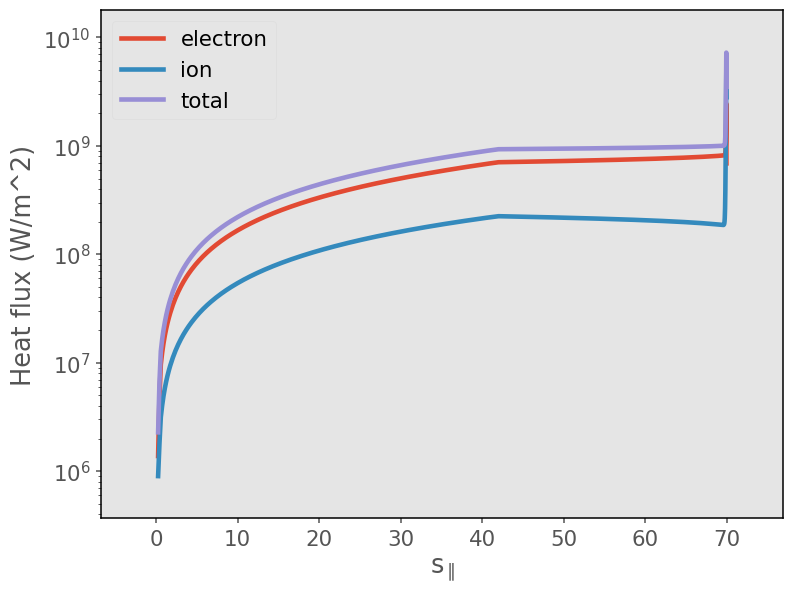

In [5]:
sh = ds[(ds['alpha'] == 'SH') & (ds['neon_frac'] == 0.0)]

x = sh['y']
q_electron = spitzer_q_electron(sh)
q_ion = spitzer_q_ion(sh)


q_total = q_electron + q_ion

fig,ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(x, q_electron, label='electron', linewidth=linewidth)
ax.plot(x, q_ion, label='ion', linewidth=linewidth)
ax.plot(x, q_total, label='total', linewidth=linewidth)
ax.set_yscale('log')
ax.set_ylabel('Heat flux (W/m^2)')
ax.set_xlabel(r's$_{\parallel}$')
ax.legend()

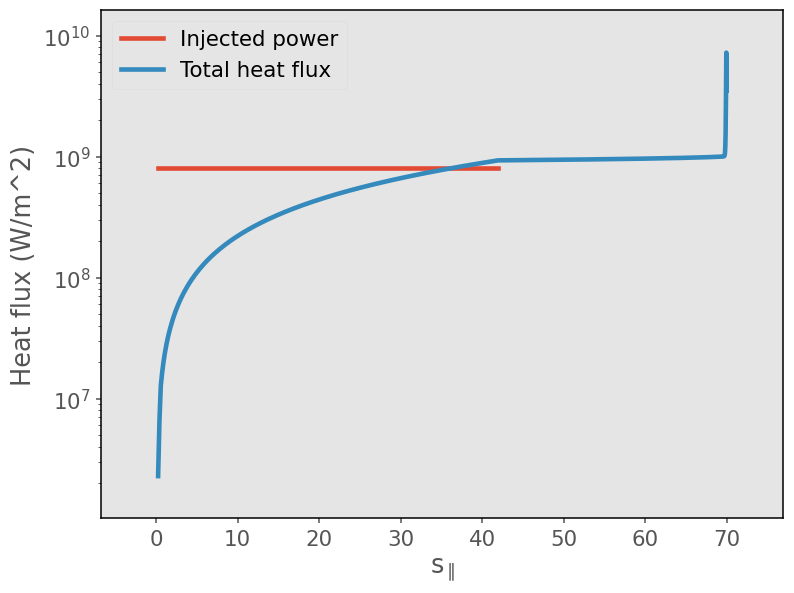

In [6]:
import numpy as np
x = sh['y']

x_point = 42
x_point_index = np.argmin(np.abs(x - x_point))


power_injection_electrons = np.array([4e8]*len(x[:x_point_index]))
power_injection_ions = np.array([4e8]*len(x[:x_point_index]))
power_injection_total = power_injection_electrons + power_injection_ions
power_injection_total = power_injection_total

fig,ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(x[:x_point_index], power_injection_total, label='Injected power', linewidth=linewidth)
ax.plot(x, q_total, label='Total heat flux', linewidth=linewidth)
ax.set_yscale('log')
ax.set_ylabel('Heat flux (W/m^2)')
ax.set_xlabel(r's$_{\parallel}$')
ax.legend()


Text(0.5, 0, 's$_{\\parallel}$')

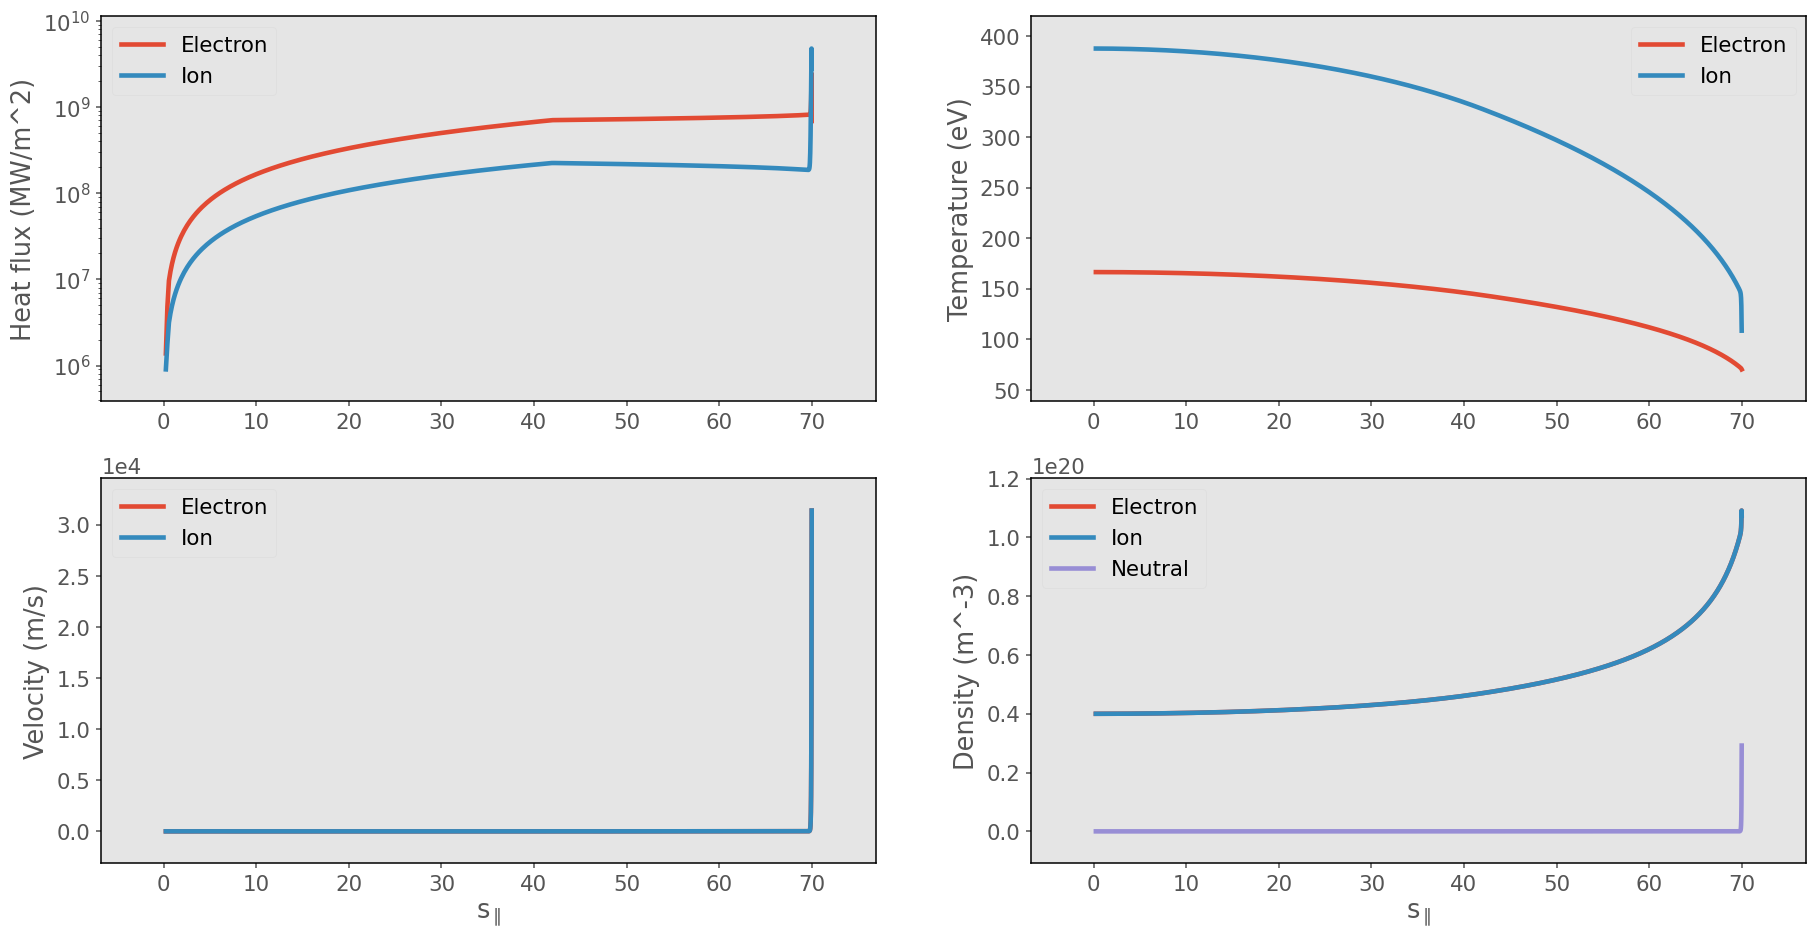

In [7]:
sh = ds[(ds['alpha'] == 'SH') & (ds['neon_frac'] == 0.0)]
x = sh['y']
q_electron = spitzer_q_electron(sh)
q_ion = spitzer_q_ion(sh)

fig,ax = plt.subplots(2,2, figsize=(20, 10))

ax[0,0].plot(x, q_electron, label='Electron', linewidth=linewidth)
# plt.yscale('log')
ax[0,0].plot(x, q_ion, label='Ion', linewidth=linewidth)
ax[0,0].set_ylabel('Heat flux (MW/m^2)')
ax[0,0].set_yscale('log')
ax[0,0].legend()

ax[0,1].plot(x, sh['Te'], label='Electron', linewidth=linewidth)
ax[0,1].plot(x, sh['Td+'], label='Ion', linewidth=linewidth)
ax[0,1].legend()
ax[0,1].set_ylabel('Temperature (eV)')

ax[1,0].plot(x, sh['Ve'], label='Electron', linewidth=linewidth)
ax[1,0].plot(x, sh['Vd+'], label='Ion', linewidth=linewidth)
ax[1,0].set_ylabel('Velocity (m/s)')
ax[1,0].legend()
ax[1,0].set_xlabel(r's$_{\parallel}$')


ax[1,1].plot(x, sh['Ne'], label='Electron', linewidth=linewidth)
ax[1,1].plot(x, sh['Nd+'], label='Ion', linewidth=linewidth)
ax[1,1].plot(x, sh['Nd'], label='Neutral', linewidth=linewidth)
ax[1,1].legend()
ax[1,1].set_ylabel('Density (m^-3)')
ax[1,1].set_xlabel(r's$_{\parallel}$')

0         -0.519024
1         -0.647140
2         -0.779643
3         -0.773379
4         -0.615890
           ...     
793     4265.479758
794     5821.101662
795     7982.715670
796    10782.091259
797    12656.456276
Length: 798, dtype: float64


(0.0, 10.0)

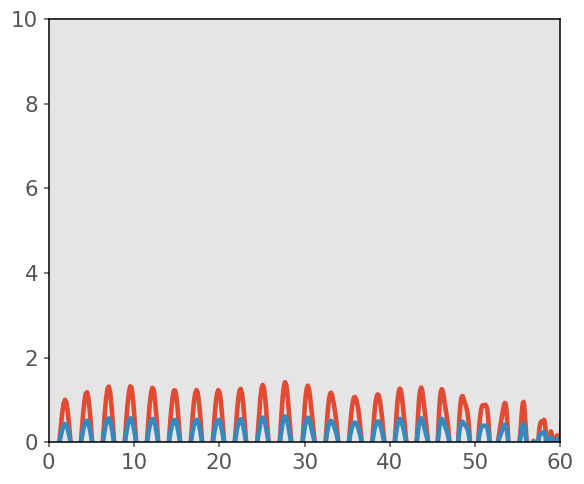

In [8]:
ion_conv = q_convective_ion(sh)
electron_conv = q_convective_electron(sh)

print(ion_conv)


plt.plot(x, ion_conv, label='Ion', linewidth=linewidth)
plt.plot(x, electron_conv, label='Electron', linewidth=linewidth)
plt.xlim(0,60)
plt.ylim(0,10)

# Testing SH ion flux models 

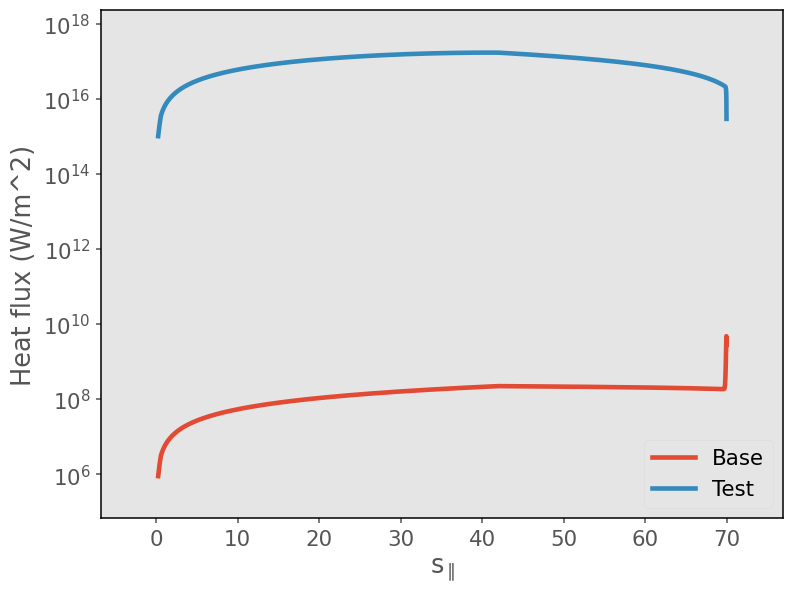

In [9]:
sh = ds[(ds['alpha'] == 'SH') & (ds['neon_frac'] == 0.0)]

x = sh['y']

q_ion_base = spitzer_q_ion(sh)

q_ion_test = test_spitzer_q_ion(sh)

q_ion_simple = spitzer_q_ion_simple(sh)

fig,ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(x, q_ion_base, label='Base', linewidth=linewidth)
ax.plot(x, q_ion_test, label='Test', linewidth=linewidth)
# ax.plot(x, q_ion_simple, label='Simple', linewidth=linewidth)
ax.set_yscale('log')
ax.set_ylabel('Heat flux (W/m^2)')
ax.set_xlabel(r's$_{\parallel}$')
ax.legend()


Pretty clear that the ion thermal speed is important here... and that the way I'm currently doing it in spitzer_q_ion is correct... or at least more correct!

In [10]:
Te = sh['Te']
Ti = sh['Td+']

log_Ti = np.log(Ti)
log_Te = np.log(Te)

print('log_Ti', log_Ti)
print('log_Te', log_Te)

log_Ti 0      5.960199
1      5.960195
2      5.960183
3      5.960167
4      5.960147
         ...   
793    4.891336
794    4.856500
795    4.807416
796    4.737244
797    4.687921
Name: Td+, Length: 798, dtype: float64
log_Te 0      5.115313
1      5.115311
2      5.115301
3      5.115286
4      5.115268
         ...   
793    4.262891
794    4.260581
795    4.257705
796    4.254148
797    4.253257
Name: Te, Length: 798, dtype: float64


# Checking SH vs SNB for higher collisionalities, should trend to the same! 

In [11]:
SH_high_coll = xh.open('/shared/storage/plasmahwdisks/data/jlb647/simulation_data/flux_limiter_detachment/2023-12-15_wigram_reference_detached/old_detached').isel(t=-1)
snb_high_coll = xh.open('/shared/storage/plasmahwdisks/data/jlb647/simulation_data/flux_limiter_detachment/2023-12-15_wigram_reference_detached/old_detached_snb').isel(t=-1)

OSError: No datafiles found matching datapath=/shared/storage/plasmahwdisks/data/jlb647/simulation_data/flux_limiter_detachment/2023-12-15_wigram_reference_detached/old_detached/BOUT.dmp.*.nc

In [ ]:
# Constants
e = 1.602e-19  # Electron charge in Coulombs
m_e = 9.109e-31  # Electron mass in kg
pi = np.pi
k0 = 13.58  # Given constant
epsilon_0 = 8.85e-12  # Permittivity of free space in F/m
k_B = 1.38e-23  # Boltzmann constant, J/K

def spitzer_q_electron(dataset):
    Z = 1  # Average ion charge, example value
    x = np.ravel(dataset['y'].values)
    Te = np.ravel(dataset['Te'].values)
    Ne = np.ravel(dataset['Ne'].values)
    Ni = np.ravel(dataset['Nd+'].values)

    Y = 4 * pi * (e**2 / (4 * pi * epsilon_0 * m_e))**2
    ln_alpha = 6.6 - 0.5 * np.log(Ne / 1e20) + 1.5 * np.log(Te)
    v_t = np.sqrt(2 * e * Te / m_e)
    lambda_ei = (v_t**4) / (Y * Ni * ln_alpha)
    tau_t = lambda_ei / v_t
    grad_T = np.gradient(Te, x)  # Assuming x and Te are 1D arrays

    q = -((Ne * e * Te) / (m_e)) * ((3 * np.sqrt(pi)) / 4) * (tau_t * k0) * ((1 + 0.24) / (1 + 4.2)) * grad_T
    q_SH_electron = q * e  # Convert from ev/m^2/s to W/m^2

    return xr.DataArray(q_SH_electron, dims=["y"], coords={"y": x})


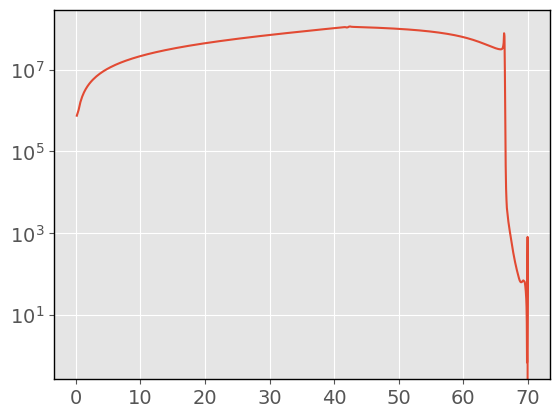

In [ ]:
Te = np.ravel(SH_high_coll['Te'].values)
y = np.ravel(SH_high_coll['y'].values)

q_electron = spitzer_q_electron(SH_high_coll)


# plt.plot(y, Te, label='SH')
plt.plot(y, q_electron, label='SH')
# SH_high_coll['Te'].plot()
plt.yscale('log')
# snb_high_coll['Te'].plot()


# same again but for /500MW_5x10(19) with 1% neon


In [ ]:

SH_higher_coll = xh.open('/shared/storage/plasmahwdisks/data/jlb647/simulation_data/flux_limiter_detachment/2023-12-15_wigram_reference_detached/500MW_5x10(19)').isel(t=-1)
snb_higher_coll = xh.open('/shared/storage/plasmahwdisks/data/jlb647/simulation_data/flux_limiter_detachment/2023-12-15_wigram_reference_detached/500MW_5x10(19)_snb').isel(t=-1)


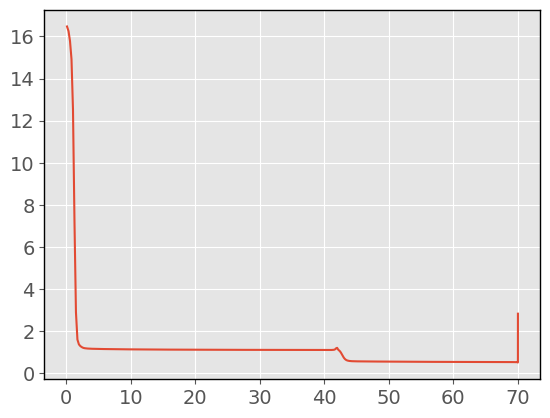

In [ ]:
Te = np.ravel(SH_higher_coll['Te'].values)
y = np.ravel(SH_higher_coll['y'].values)

plt.plot(y, Te, label='SH')

In [ ]:
recyc_ds = Load.case_1D(
    '/users/jlb647/scratch/simulation_program/hermes-3/examples/1D-recycling').ds
recyc_ds_fl = Load.case_1D(
    '/users/jlb647/scratch/simulation_program/hermes-3/examples/1D-recycling-flux-limited_02').ds

Unnormalising with xHermes
Unnormalising with xHermes


In [ ]:

sh_ds = recyc_ds.isel(t=-1, pos = slice(1,-1))
fl_ds = recyc_ds_fl.isel(t=-1, pos = slice(1,-1))



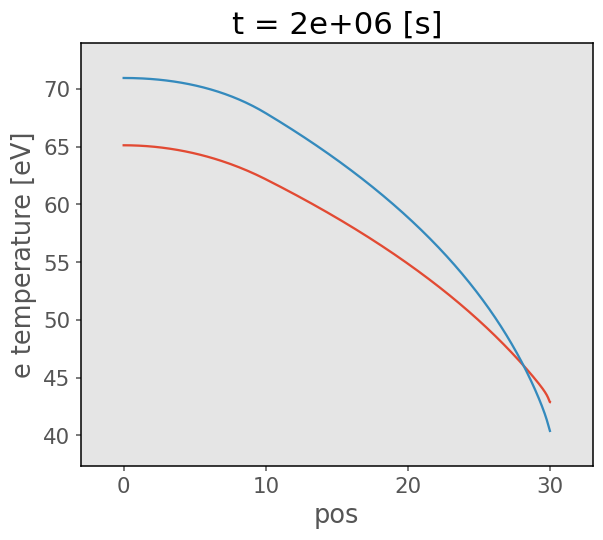

In [ ]:
sh_ds['Te'].plot()
fl_ds['Te'].plot()

In [ ]:
def spitzer_simple(xarray):
    Te = xarray['Te'].values
    grad_Te = np.gradient(Te)
    kappa_par_e = xarray['kappa_par_e'].values

    q = -kappa_par_e * grad_Te

    return q




In [ ]:
print(sh_ds)

<xarray.Dataset>
Dimensions:                        (pos: 402, y: 404)
Coordinates:
    dx                             (pos) float64 dask.array<chunksize=(402,), meta=np.ndarray>
    dy                             (pos) float64 dask.array<chunksize=(402,), meta=np.ndarray>
    dz                             (pos) float64 dask.array<chunksize=(402,), meta=np.ndarray>
    t                              float64 2e+06
  * y                              (y) float64 0.0715 0.2143 ... 30.29 30.3
  * pos                            (pos) float64 0.0 0.07125 ... 30.0 30.0
Data variables: (12/66)
    Bxy                            (pos) float64 dask.array<chunksize=(402,), meta=np.ndarray>
    Ed_target_recycle              (pos) float64 dask.array<chunksize=(402,), meta=np.ndarray>
    G1                             (pos) float64 dask.array<chunksize=(402,), meta=np.ndarray>
    G2                             (pos) float64 dask.array<chunksize=(402,), meta=np.ndarray>
    G3                     

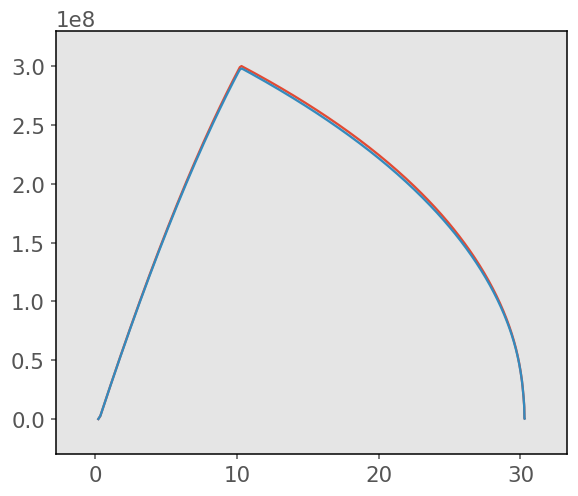

In [ ]:
sh_q =  spitzer_simple(sh_ds)
fl_q = spitzer_simple(fl_ds)

# sh_q = replace_guards(sh_q)
# fl_q = replace_guards(fl_q)

y = sh_ds['y'].values
y = y[1:-1]

plt.plot(y, sh_q, label='SH')
plt.plot(y, fl_q, label='FL')
# plt.yscale('log')

So what this tells us is that something is going wrong in the calculation for heat flux, it's obvious that doing what hermes-3 does to find the heat flux (q = -kappa gradT) is overestimating the total powerflux, the method given in BOUT++ documentation does seem better, but not power balance perfect 

MovieWriter imagemagick unavailable; using Pillow instead.


(401, 400)
Updating frame: 0, time=0.0
Updating frame: 0, time=0.0
Updating frame: 0, time=0.0
Updating frame: 0, time=0.0
Updating frame: 1, time=5000.0
Updating frame: 2, time=10000.0
Updating frame: 3, time=15000.0
Updating frame: 4, time=20000.0
Updating frame: 5, time=25000.0
Updating frame: 6, time=30000.0
Updating frame: 7, time=35000.0
Updating frame: 8, time=40000.0
Updating frame: 9, time=45000.0
Updating frame: 10, time=50000.0
Updating frame: 11, time=55000.0
Updating frame: 12, time=60000.0
Updating frame: 13, time=65000.0
Updating frame: 14, time=70000.0
Updating frame: 15, time=75000.0
Updating frame: 16, time=80000.0
Updating frame: 17, time=85000.0
Updating frame: 18, time=90000.0
Updating frame: 19, time=95000.0
Updating frame: 20, time=100000.0
Updating frame: 21, time=105000.0
Updating frame: 22, time=110000.0
Updating frame: 23, time=115000.0
Updating frame: 24, time=120000.0
Updating frame: 25, time=125000.0
Updating frame: 26, time=130000.0
Updating frame: 27, ti

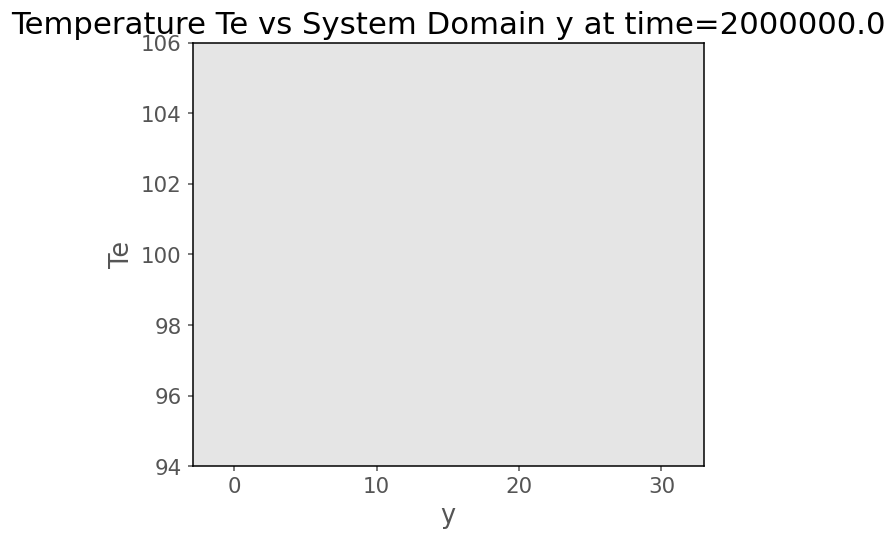

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import xarray as xr
import numpy as np


ds = xh.open('/users/jlb647/scratch/simulation_program/hermes-3/examples/1D-recycling')
# Select the temperature variable
# Select the temperature variable, e.g., 'Te'
temperature = ds['Te']  # replace 'Te' with the actual name of the temperature variable

# Ensure that the temperature variable has dimensions (time, y)
time = ds['t']  # replace with your actual time coordinate name if different
y = ds['y']  # replace with your actual y coordinate name if different

# Convert to numpy array if needed
temperature_data = temperature.squeeze().values  # this should result in shape (401, 400)

print(temperature_data.shape)

# Define the figure and axis
fig, ax = plt.subplots()

# Initialize the plot with the first frame
line, = ax.plot(y, temperature_data[0, :], lw=2)
ax.set_xlabel('y')
ax.set_ylabel('Te')
ax.set_title('Temperature Te vs System Domain y')

# Define the update function for the animation
def update(frame):
    line.set_ydata(temperature_data[frame, :])
    ax.set_title(f'Temperature Te vs System Domain y at time={time.values[frame]}')
    print(f'Updating frame: {frame}, time={time.values[frame]}')  # Debug print
    # print(temperature_data[frame, :])  # Debug print to check data
    return line,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=temperature_data.shape[0], blit=True, repeat=False)

# Save or display the animation
ani.save('Te_vs_y_animation.gif', writer='imagemagick')  # or use plt.show() to display

plt.show()


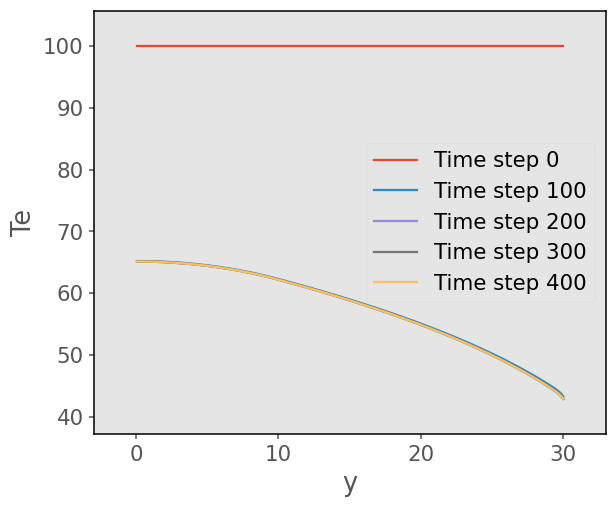

In [ ]:
# Plot a few frames statically
plt.figure()
for i in range(0, temperature_data.shape[0], 100):  # Plot every 100th frame
    plt.plot(y, temperature_data[i, :], label=f'Time step {i}')
plt.xlabel('y')
plt.ylabel('Te')
plt.legend()
plt.show()


In [ ]:
ds = Load.case_1D(
    '/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/updated_flux_limitation/2024-03-25_wigram_reference_glover_comparison_FINAL/alpha_0.06/neon_0.0').ds

/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/hermes-3_venv/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Unnormalising with xHermes


/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/hermes-3_venv/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


In [ ]:
ds = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/updated_flux_limitation/2024-03-25_wigram_reference_glover_comparison_FINAL/alpha_0.06/neon_0.0')
# Select the temperature variable


/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/hermes-3_venv/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


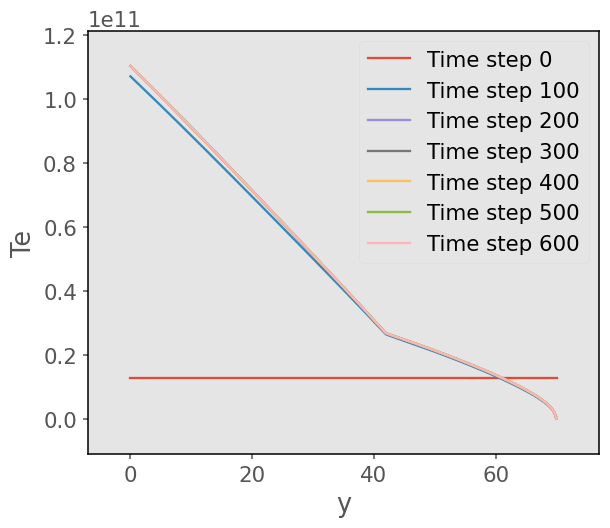

In [ ]:
# Select the temperature variable, e.g., 'Te'
temperature = ds['kappa_par_e']  # replace 'Te' with the actual name of the temperature variable

# Ensure that the temperature variable has dimensions (time, y)
time = ds['t']  # replace with your actual time coordinate name if different
y = ds['y']  # replace with your actual y coordinate name if different

# Convert to numpy array if needed
temperature_data = temperature.squeeze().values  # this should result in shape (401, 400)
# Plot a few frames statically
plt.figure()
for i in range(0, temperature_data.shape[0], 100):  # Plot every 100th frame
    plt.plot(y, temperature_data[i, :], label=f'Time step {i}')
plt.xlabel('y')
plt.ylabel('Te')
plt.legend()
plt.show()

In [12]:
import numpy as np

class Mesh:
    def __init__(self, LocalNy):
        self.LocalNx = 1
        self.LocalNy = LocalNy
        self.LocalNz = 1
        self.ystart = 1
        self.yend = LocalNy - 2

class Coordinates:
    def __init__(self, dy, g_22):
        self.dy = dy
        self.g_22 = g_22

class Field3D:
    def __init__(self, data, mesh, coordinates):
        self.data = data
        self.mesh = mesh
        self.coordinates = coordinates

    def yup(self):
        return np.roll(self.data, -1, axis=1)

    def ydown(self):
        return np.roll(self.data, 1, axis=1)

    def __getitem__(self, indices):
        return self.data[indices]

    def __setitem__(self, indices, value):
        self.data[indices] = value

def empty_from(f):
    return np.zeros_like(f.data)

def Grad_par(var):
    mesh = var.mesh
    coordinates = var.coordinates

    result = Field3D(empty_from(var), mesh, coordinates)
    ny = mesh.LocalNy

    for y in range(1, ny - 1):
        by = 1.0 / np.sqrt(coordinates.g_22[0, y, 0])
        zm = (y - 1 + ny) % ny
        zp = (y + 1) % ny

        gradient = (var[0, zp, 0] - var[0, zm, 0]) / \
                   (0.5 * coordinates.dy[0, zp, 0] + coordinates.dy[0, y, 0] +
                    0.5 * coordinates.dy[0, zm, 0])

        result[0, y, 0] = by * gradient

    return result

# Define the mesh
LocalNy = 800
mesh = Mesh(LocalNy)

# Define non-uniform grid spacing
length = 1.0  # Total length of the domain
pi = np.pi
y = np.linspace(0, pi, LocalNy)
dymin = 0.1  # Minimum grid spacing near target, as fraction of average. Must be > 0 and < 1
dy = (length / LocalNy) * (1 + (1-dymin)*(1-y/pi))
dy = dy.reshape(1, LocalNy, 1)

# Define coordinates
g_22 = np.ones((1, LocalNy, 1))  # Assuming a simple metric tensor component

coordinates = Coordinates(dy, g_22)

# Initialize field data
data_T = np.random.rand(1, LocalNy, 1)  # Example temperature data
data_kappa_par = np.random.rand(1, LocalNy, 1)  # Example kappa_par data

T = Field3D(data_T, mesh, coordinates)
kappa_par = Field3D(data_kappa_par, mesh, coordinates)

# Calculate the Spitzer-Harm heat flux
grad_T = Grad_par(T)
q_SH = Field3D(kappa_par.data * grad_T.data, mesh, coordinates)

print("Heat flux (q_SH):")
print(q_SH.data)



Heat flux (q_SH):
[[[ 0.00000000e+00]
  [-3.50555889e-02]
  [-1.70336029e-02]
  [-1.14297646e-02]
  [ 1.30830695e-03]
  [ 1.55121290e-01]
  [-8.22322533e-02]
  [ 2.37143286e-01]
  [ 1.22342176e-01]
  [-2.48081381e-01]
  [-1.67664310e-01]
  [ 2.25459527e-01]
  [-8.84454013e-02]
  [ 3.58198574e-02]
  [ 4.13512932e-04]
  [-1.23925291e-02]
  [ 4.64755322e-03]
  [-8.59349908e-02]
  [ 7.12224541e-02]
  [-5.76615703e-03]
  [-6.64547709e-02]
  [ 9.17233417e-02]
  [ 5.61560979e-03]
  [ 5.09568491e-02]
  [-1.25656296e-02]
  [-3.98728564e-04]
  [ 1.20034467e-01]
  [-1.46471822e-02]
  [-7.71311679e-02]
  [ 6.33830660e-02]
  [ 6.41856866e-02]
  [-1.46038757e-01]
  [-9.75212229e-02]
  [ 6.81812654e-02]
  [ 2.90707930e-01]
  [-3.03105850e-02]
  [-1.89700201e-02]
  [ 1.21178790e-01]
  [-5.32732378e-02]
  [-4.40713978e-02]
  [ 1.50109188e-02]
  [ 7.00223411e-04]
  [ 8.76316834e-03]
  [-6.53248226e-03]
  [ 3.76435611e-02]
  [-1.84662891e-02]
  [-3.70726911e-02]
  [ 4.05822115e-02]
  [-1.87978915e-02]
  